In [114]:
import pandas as pd
df = pd.read_csv('../data/spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [115]:
df = df.rename(columns={'v1': 'label', 'v2': 'message'})
df.head()

,label,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [116]:
columns_to_drop = [col for col in df.columns if 'Unnamed' in col]
df = df.drop(columns=columns_to_drop)
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [117]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [118]:
df.isnull().sum()

label      0
message    0
dtype: int64

In [119]:
df.drop_duplicates(keep="first", inplace=True)
df.duplicated().sum()

np.int64(0)

In [120]:
df['label'].value_counts(normalize=True)

label
0    0.87367
1    0.12633
Name: proportion, dtype: float64

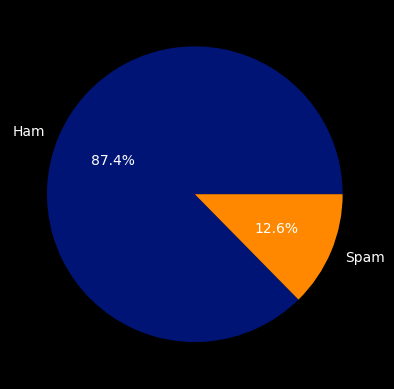

In [121]:
from matplotlib import pyplot as plt

my_colors = ['#001475', '#FF8800']
plt.pie(df['label'].value_counts(normalize=True), labels=["Ham", "Spam"], colors=my_colors, autopct="%1.1f%%")
plt.show()

In [122]:
import re
from bs4 import BeautifulSoup

def preprocess_text(text):
    """
    Preprocessing rules:
    - Remove HTML & headers
    - Normalize whitespace
    - Lowercase text
    - Replace URLs and emails with tokens
    - Keep punctuation signals (! ? $)
    """

    if not isinstance(text, str):
        return ""

    # 1. Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # 2. Remove common email headers
    text = re.sub(r'(subject|from|to|date):', ' ', text, flags=re.IGNORECASE)

    # 3. Replace URLs with token
    text = re.sub(r'(http\S+|www\S+)', ' URL ', text)

    # 4. Replace email addresses with token
    text = re.sub(r'\S+@\S+', ' EMAIL ', text)

    # 5. Lowercase
    text = text.lower()

    # 6. Keep punctuation signals, remove other junk
    text = re.sub(r'[^a-z0-9!?$]', ' ', text)

    # 7. Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [123]:
df["message_length"] = df.apply(lambda x: len(x["message"]), axis=1)
df["clean_msg"] = df.apply(lambda x: preprocess_text(x["message"]), axis=1)
df["preprocess_length"] = df.apply(lambda x: len(x["clean_msg"]), axis=1)
df.head()

,label,message,message_length,clean_msg,preprocess_length
0,0,"Go until jurong point, crazy.. Available only ...",111,go until jurong point crazy available only in ...,102
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni,23
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry in 2 a wkly comp to win fa cup fina...,154
3,0,U dun say so early hor... U c already then say...,49,u dun say so early hor u c already then say,43
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah i don t think he goes to usf he lives arou...,60


In [124]:
from sklearn.model_selection import train_test_split

X = df['clean_msg']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    analyzer='word',
    min_df=2,
    max_df=0.95,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [126]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(class_weight={0:1, 1:2},max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*","{0: 1, 1: 2}"
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For 

In [127]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_model(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]
    threshold = 0.27
    y_pred_final = (y_prob >= threshold).astype(int)

    print(f"Confusion Matrix (Threshold = {threshold})")
    print(confusion_matrix(y_test, y_pred_final))

    print(f"\nClassification Report (Threshold = {threshold})")
    print(classification_report(y_test, y_pred_final, target_names=["Ham", "Spam"]))

In [128]:
evaluate_model(lr_model, X_test_tfidf, y_test)

Confusion Matrix (Threshold = 0.27)
[[894   9]
 [ 12 119]]

Classification Report (Threshold = 0.27)
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       903
        Spam       0.93      0.91      0.92       131

    accuracy                           0.98      1034
   macro avg       0.96      0.95      0.95      1034
weighted avg       0.98      0.98      0.98      1034



In [129]:
y_prob = lr_model.predict_proba(X_test_tfidf)[:, 1]
threshold = 0.25
y_pred_final = (y_prob >= threshold).astype(int)

test_df = pd.DataFrame({
    "text": X_test.values,
    "true_label": y_test.values,
    "pred_label": y_pred_final
})

false_negatives = test_df[
    (test_df.true_label == 1) & (test_df.pred_label == 0)
]

false_positives = test_df[
    (test_df.true_label == 0) & (test_df.pred_label == 1)
]

In [130]:
false_negatives.sample(5)["text"]

329             sms ac sun0819 posts hello you seem cool
486    in the simpsons movie released in july 2007 na...
230    asked 3mobile if 0870 chatlines inclu in free ...
801    would you like to see my xxx pics they are so ...
308    hi its lucy hubby at meetins all day fri i wil...
Name: text, dtype: object

In [131]:
false_positives.sample(5)["text"]

327                                  k k sms chat with me
965     hi! you just spoke to maneesha v we d like to ...
1003          aldrine rakhesh ex rtm here pls call urgent
454                   u will switch your fone on dammit!!
739     hey great deal farm tour 9am to 5pm $95 pax $5...
Name: text, dtype: object

In [132]:
"""
Confusion Matrix (Threshold = 0.3)
[[899   4]
 [ 20 111]]

Classification Report (Threshold = 0.3)
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       903
        Spam       0.97      0.85      0.90       131

    accuracy                           0.98      1034
   macro avg       0.97      0.92      0.94      1034
weighted avg       0.98      0.98      0.98      1034
"""

'\nConfusion Matrix (Threshold = 0.3)\n[[899   4]\n [ 20 111]]\n\nClassification Report (Threshold = 0.3)\n              precision    recall  f1-score   support\n\n         Ham       0.98      1.00      0.99       903\n        Spam       0.97      0.85      0.90       131\n\n    accuracy                           0.98      1034\n   macro avg       0.97      0.92      0.94      1034\nweighted avg       0.98      0.98      0.98      1034\n'

In [133]:
feature_names = tfidf.get_feature_names_out()
coefficients = lr_model.coef_[0]

In [134]:
top_spam_indices = np.argsort(coefficients)[-20:]
top_spam_words = [(feature_names[i], coefficients[i]) for i in top_spam_indices]

top_spam_words

[('uk', np.float64(2.140139270324088)),
 ('win', np.float64(2.2456874555389534)),
 ('prize', np.float64(2.2552715455164147)),
 ('now', np.float64(2.278677420411953)),
 ('150p', np.float64(2.31498754078531)),
 ('chat', np.float64(2.3321528795066087)),
 ('50', np.float64(2.4182311434484283)),
 ('for', np.float64(2.4226514017625593)),
 ('from', np.float64(2.4598936201907247)),
 ('claim', np.float64(2.8079805411672707)),
 ('your', np.float64(2.950191231762987)),
 ('stop', np.float64(3.1007286029633825)),
 ('to', np.float64(3.192492496189256)),
 ('mobile', np.float64(3.308528933069503)),
 ('reply', np.float64(3.6401401886763263)),
 ('free', np.float64(3.799435048277208)),
 ('text', np.float64(3.819746644642462)),
 ('url', np.float64(4.431298682647652)),
 ('txt', np.float64(4.47776501932354)),
 ('call', np.float64(5.4197390488806745))]

In [135]:
top_ham_indices = np.argsort(coefficients)[:20]
top_ham_words = [(feature_names[i], coefficients[i]) for i in top_ham_indices]

top_ham_words

[('my', np.float64(-2.3585069675532497)),
 ('me', np.float64(-2.0759421044979356)),
 ('that', np.float64(-1.865148081857798)),
 ('ok', np.float64(-1.637999315474257)),
 ('it', np.float64(-1.5372422447706318)),
 ('at', np.float64(-1.5188654956029937)),
 ('but', np.float64(-1.4579658220289649)),
 ('how', np.float64(-1.454748475427331)),
 ('what', np.float64(-1.326562550269897)),
 ('come', np.float64(-1.318677611275774)),
 ('he', np.float64(-1.310071733816834)),
 ('in', np.float64(-1.2668616509387594)),
 ('home', np.float64(-1.2610173053205727)),
 ('da', np.float64(-1.260337921415515)),
 ('so', np.float64(-1.2427176714038801)),
 ('its', np.float64(-1.2091622690361867)),
 ('ll', np.float64(-1.1993916319883746)),
 ('got', np.float64(-1.192064253059566)),
 ('going', np.float64(-1.1851983725089037)),
 ('then', np.float64(-1.170088103966709))]

In [136]:
"""
Naive Bayes - Confusion Matrix
[[903   0]
 [ 40  91]]

Naive Bayes - Classification Report
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       903
        Spam       1.00      0.69      0.82       131

    accuracy                           0.96      1034
   macro avg       0.98      0.85      0.90      1034
weighted avg       0.96      0.96      0.96      1034


Logistic Regression - Confusion Matrix
[[902   1]
 [ 39  92]]

Logistic Regression - Classification Report
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       903
        Spam       0.99      0.70      0.82       131

    accuracy                           0.96      1034
   macro avg       0.97      0.85      0.90      1034
weighted avg       0.96      0.96      0.96      1034
"""

'\nNaive Bayes - Confusion Matrix\n[[903   0]\n [ 40  91]]\n\nNaive Bayes - Classification Report\n              precision    recall  f1-score   support\n\n         Ham       0.96      1.00      0.98       903\n        Spam       1.00      0.69      0.82       131\n\n    accuracy                           0.96      1034\n   macro avg       0.98      0.85      0.90      1034\nweighted avg       0.96      0.96      0.96      1034\n\n\nLogistic Regression - Confusion Matrix\n[[902   1]\n [ 39  92]]\n\nLogistic Regression - Classification Report\n              precision    recall  f1-score   support\n\n         Ham       0.96      1.00      0.98       903\n        Spam       0.99      0.70      0.82       131\n\n    accuracy                           0.96      1034\n   macro avg       0.97      0.85      0.90      1034\nweighted avg       0.96      0.96      0.96      1034\n'